## Import Dependencies

In [1]:
import numpy as np
from skimage import feature
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request
from sklearn.cluster import MeanShift


## Function to read images from Web addresses.


In [2]:
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

## Function to Mask region of Interest.


In [3]:

#Mask region of Interest.
def mask_img(image, vertices):
    # Ensure mask is the same size as the image and 8-bit single-channel
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    
    # Add white to the region of interest
    cv2.fillPoly(mask, vertices, 255)
    
    # Make sure the image is in the correct format if it is colored
    if len(image.shape) == 3:
        masked_image = cv2.bitwise_and(image, image, mask=mask)
    else:  # If the image is already grayscale
        masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    return mask, masked_image


### Read in test image


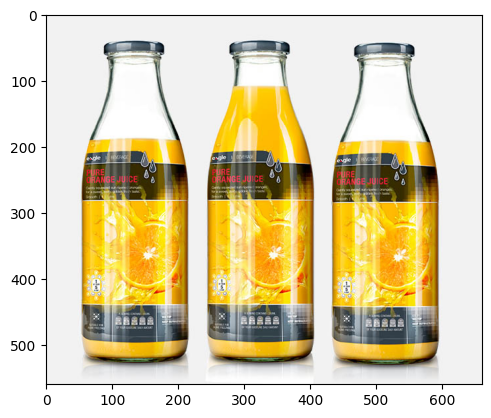

In [4]:
image_url = "https://cdn.eaglepi.com/uploads/2016/08/NEW_Fill_level_Rounded_Image_660pxh.jpg"

image = url_to_image(image_url)
plt.imshow(image)

## Step 1: Convert the image to grayscale and apply Gaussian blur


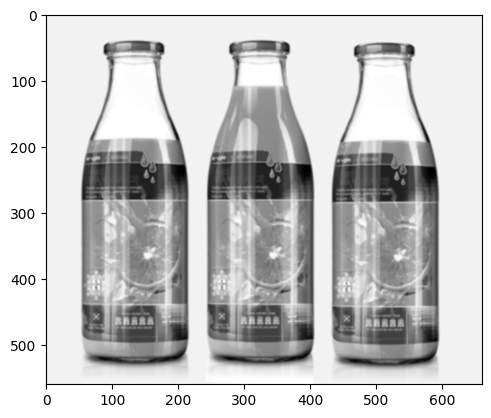

In [5]:
# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap='gray')

# Step 1: Convert the image to grayscale and apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5,5), 0)

plt.imshow(blurred, cmap='gray')

## Step 2: Apply Canny Algorithm


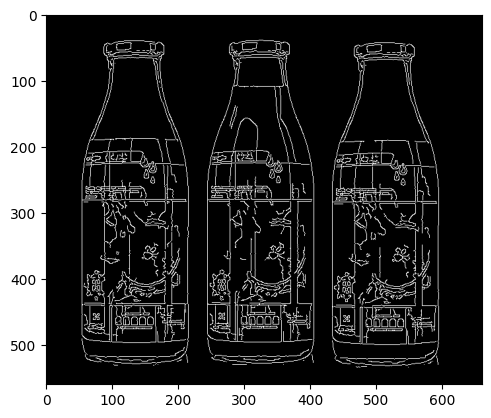

In [6]:
min_thres = 80
max_thres = 150
edges = cv2.Canny(blurred,min_thres,max_thres,apertureSize = 3)
plt.imshow(edges, cmap='gray')

## Step 3: Detect contours


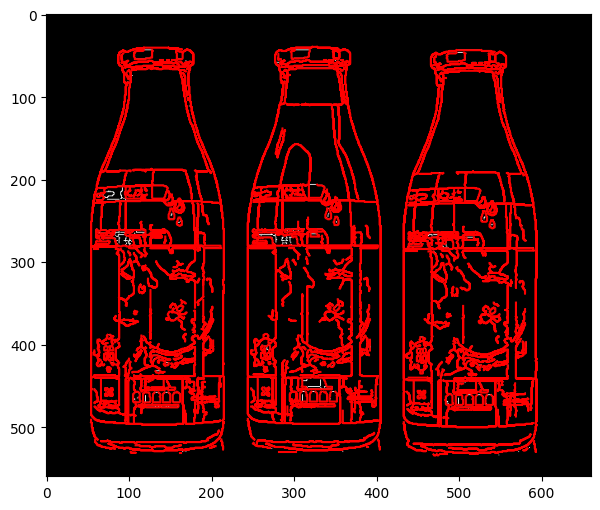

In [7]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Plot each contour individually
plt.figure(figsize=(10, 6))
for contour in contours:
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], 'r')  # Plot the contour as a red line

plt.imshow(edges, cmap='gray')
plt.show()

## Step 4: Set a fill level threshold. Adjust this based on your image


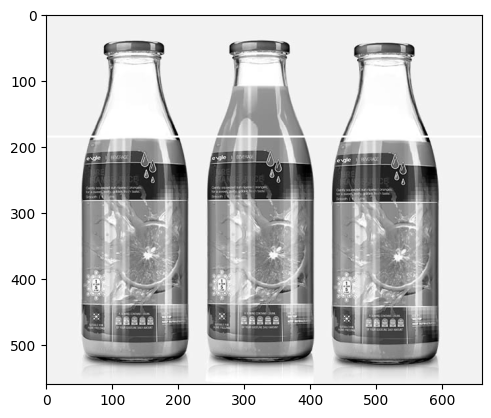

In [8]:
fill_threshold = 185
# Draw a horizontal line at the fill level threshold
cv2.line(gray, (0, fill_threshold), (image.shape[1], fill_threshold), (255, 255, 0), 2)  # Drawing a yellow line for fill level threshold

# Now display the image with the drawn threshold line
plt.imshow(gray, cmap='gray')
plt.show()


## Step 5: Mask the region of interest

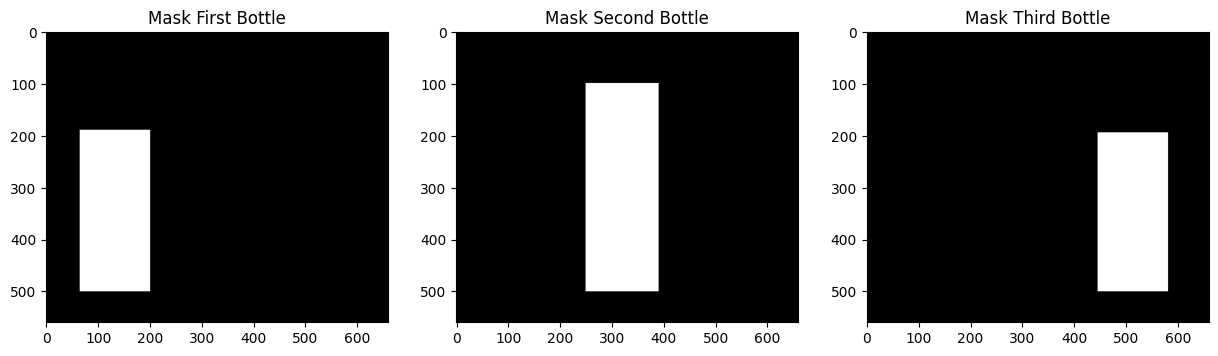

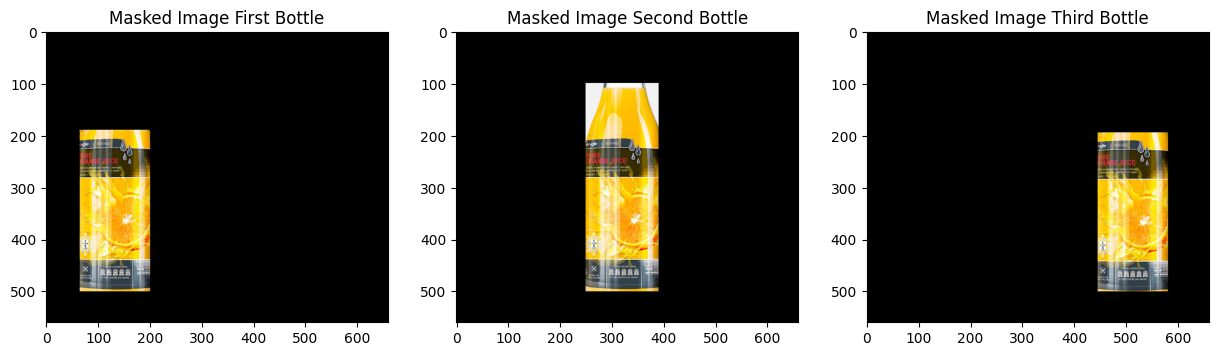

In [9]:
# Given the image width of 660 pixels and height of 560 pixels
image_width = 660
image_height = 560


# Assuming we want the mask to span from the very left of the image (x=0)
x_start_bottle_1 = 65
x_end_bottle_1 = 200  # This will cover the x-axis from 0 to 200

# Define specific y-coordinates for each bottle based on the liquid levels

# You will adjust these based on the visual inspection of each bottle's liquid level
y_start_bottle_1 = 190  # Upper boundary for the first bottle's liquid level
y_end_bottle_1 = 500    # Lower boundary for the first bottle's liquid level

y_start_bottle_2 = 100  # Upper boundary for the second bottle's liquid level
y_end_bottle_2 = 500    # Lower boundary for the second bottle's liquid level

y_start_bottle_3 = 195  # Upper boundary for the third bottle's liquid level
y_end_bottle_3 = 500    # Lower boundary for the third bottle's liquid level

# Now we set our coordinates for the first bottle's mask
l1_bottle_1 = [x_start_bottle_1, y_start_bottle_1]  # Top-left corner
l2_bottle_1 = [x_start_bottle_1, y_end_bottle_1]    # Bottom-left corner
r1_bottle_1 = [x_end_bottle_1, y_start_bottle_1]    # Top-right corner
r2_bottle_1 = [x_end_bottle_1, y_end_bottle_1]      # Bottom-right corner

# Convert to an array in the format OpenCV expects
vertices_bottle_1 = np.array([[[x_start_bottle_1, y_start_bottle_1], [x_start_bottle_1, y_end_bottle_1], [x_end_bottle_1, y_end_bottle_1], [x_end_bottle_1, y_start_bottle_1]]], dtype=np.int32)
mask_bottle_1, masked_image_bottle_1 = mask_img(image, vertices_bottle_1)

# Adjust these based on the position of the second bottle
x_start_bottle_2 = 250  # Assuming a 20-pixel gap after the first 200 pixels
x_end_bottle_2 = 390    # Another 200 pixels for the width of the second bottle

#Now we set our coordinates for the second bottle's mask
l1_bottle_2 = [x_start_bottle_2, y_start_bottle_2]  # Top-left corner
l2_bottle_2 = [x_start_bottle_2, y_end_bottle_2]    # Bottom-left corner
r1_bottle_2 = [x_end_bottle_2, y_start_bottle_2]    # Top-right corner
r2_bottle_2 = [x_end_bottle_2, y_end_bottle_2]      # Bottom-right corner

# Convert to an array in the format OpenCV expects
vertices_bottle_2 = np.array([[[x_start_bottle_2, y_start_bottle_2], [x_start_bottle_2, y_end_bottle_2], [x_end_bottle_2, y_end_bottle_2], [x_end_bottle_2, y_start_bottle_2]]], dtype=np.int32)
mask_bottle_2, masked_image_bottle_2 = mask_img(image, vertices_bottle_2)

# And similarly for the third bottle
x_start_bottle_3 = 445  # Assuming the same 20-pixel gap continues
x_end_bottle_3 = 580    # And the third bottle also spans 200 pixels in width

# Now we set our coordinates for the third bottle's mask
l1_bottle_3 = [x_start_bottle_3, y_start_bottle_3]  # Top-left corner
l2_bottle_3 = [x_start_bottle_3, y_end_bottle_3]    # Bottom-left corner 
r1_bottle_3 = [x_end_bottle_3, y_start_bottle_3]    # Top-right corner
r2_bottle_3 = [x_end_bottle_3, y_end_bottle_3]      # Bottom-right corner

# Convert to an array in the format OpenCV expects
vertices_bottle_3 = np.array([[[x_start_bottle_3, y_start_bottle_3], [x_start_bottle_3, y_end_bottle_3], [x_end_bottle_3, y_end_bottle_3], [x_end_bottle_3, y_start_bottle_3]]], dtype=np.int32)
mask_bottle_3, masked_image_bottle_3 = mask_img(image, vertices_bottle_3)

# Convert to an array in the format OpenCV expects
vertices = np.array([[l1_bottle_1, l2_bottle_1, r2_bottle_1, r1_bottle_1]], dtype=np.int32)


mask, masked_image = mask_img(image, vertices)
# Get dimensions
height, width = image.shape[:2]

# Visualize the masks and masked images for all bottles
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.title("Mask First Bottle")
plt.imshow(mask, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Mask Second Bottle")
plt.imshow(mask_bottle_2, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Mask Third Bottle")
plt.imshow(mask_bottle_3, cmap='gray')
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.title("Masked Image First Bottle")
plt.imshow(masked_image_bottle_1)
plt.subplot(1, 3, 2)
plt.title("Masked Image Second Bottle")
plt.imshow(masked_image_bottle_2)
plt.subplot(1, 3, 3)
plt.title("Masked Image Third Bottle")
plt.imshow(masked_image_bottle_3)
plt.show()

## Step 6: Apply Hough Transform to find lines


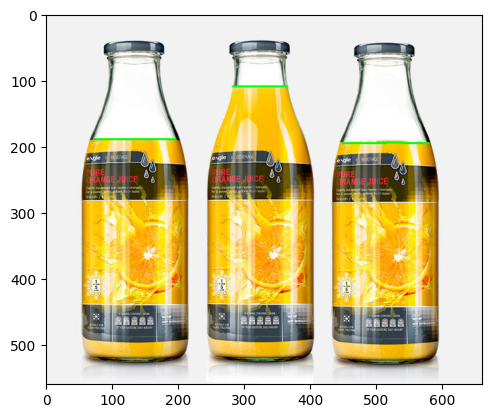

In [10]:
# Reload image
# image = image

n_max = 40
#hough lines
rho_res = 1
theta_res = np.pi/180
threshold = 50
max_line_gap = 20
expected_liquid_level_y_min = 100
expected_liquid_level_y_max = 200
# Increase the minimum line length to filter out the shorter lines
min_line_len = 40 

# Apply the masking process for the first bottle
gray_masked_image_bottle_1 = cv2.cvtColor(masked_image_bottle_1, cv2.COLOR_BGR2GRAY)
edges_bottle_1 = cv2.Canny(gray_masked_image_bottle_1, 50, 150)
# Now, apply Hough Transform to the edge-detected image
lines_bottle_1 = cv2.HoughLinesP(edges_bottle_1, rho_res, theta_res, threshold,
                                 np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Apply the same process for the second bottle
gray_masked_image_bottle_2 = cv2.cvtColor(masked_image_bottle_2, cv2.COLOR_BGR2GRAY)
edges_bottle_2 = cv2.Canny(gray_masked_image_bottle_2, 50, 150)
# Now, apply Hough Transform to the edge-detected image
lines_bottle_2 = cv2.HoughLinesP(edges_bottle_2, rho_res, theta_res, threshold,
                                 np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Apply the same process for the third bottle
gray_masked_image_bottle_3 = cv2.cvtColor(masked_image_bottle_3, cv2.COLOR_BGR2GRAY)
edges_bottle_3 = cv2.Canny(gray_masked_image_bottle_3, 50, 150)
# Now, apply Hough Transform to the edge-detected image
lines_bottle_3 = cv2.HoughLinesP(edges_bottle_3, rho_res, theta_res, threshold,
                                 np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Assuming 'image' is a copy of the original image where you want to draw the lines
filtered_image = np.copy(image)

# Filter and draw lines for the first bottle
if lines_bottle_1 is not None:
    for line in lines_bottle_1:
        for x1, y1, x2, y2 in line:
            if min(y1, y2) > expected_liquid_level_y_min and max(y1, y2) < expected_liquid_level_y_max:
                slope = (y2 - y1) / (x2 - x1 + 1e-6)  # Avoid division by zero
                if abs(slope) < 0.1:  # Horizontal enough
                    cv2.line(filtered_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Filter out lines based on their position (y-coordinates) and slope
if lines_bottle_2 is not None:
    for line in lines_bottle_2:
        for x1, y1, x2, y2 in line:
            # Check if line is within the expected y-coordinate range for the liquid level
            if min(y1, y2) > expected_liquid_level_y_min and max(y1, y2) < expected_liquid_level_y_max:
                slope = (y2 - y1) / (x2 - x1 + 1e-6)  # Adding epsilon to avoid division by zero
                # Check if the line is horizontal enough
                if abs(slope) < 0.1:  # You may adjust this threshold as needed
                    cv2.line(filtered_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Filter and draw lines for the third bottle
if lines_bottle_3 is not None:
    for line in lines_bottle_3:
        for x1, y1, x2, y2 in line:
            if min(y1, y2) > expected_liquid_level_y_min and max(y1, y2) < expected_liquid_level_y_max:
                slope = (y2 - y1) / (x2 - x1 + 1e-6)  # Avoid division by zero
                if abs(slope) < 0.1:  # Horizontal enough
                    cv2.line(filtered_image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(filtered_image)
plt.show()


## Display the image with the status of each bottle

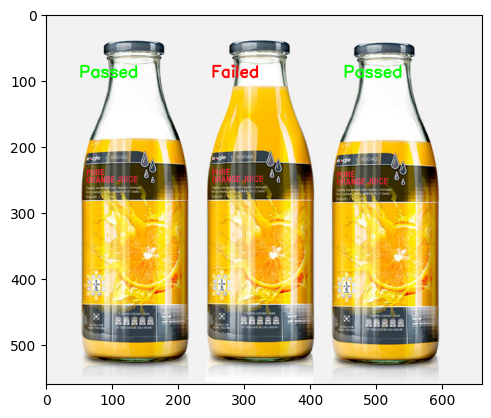

In [11]:
# Function to add status text onto the image
def add_status_text(image, x, y, status):
    if status == "Failed":
        color = (255, 0, 0)  # Red color in BGR
    else:
        color = (0, 255, 0)  # Green color in BGR
    
    cv2.putText(image, status, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

# Example y-coordinates for the detected liquid levels in each bottle
# Replace these with the actual detected y-coordinates from your analysis
detected_levels = {
    "bottle_1": 180,  # Example detected level for bottle 1
    "bottle_2": 195,  # Example detected level for bottle 2
    "bottle_3": 180   # Example detected level for bottle 3
}

# Coordinates for placing the status text for each bottle
# Adjust these based on where you want the text to appear
text_coords = {
    "bottle_1": (50, fill_threshold - 90),
    "bottle_2": (250, fill_threshold - 90),
    "bottle_3": (450, fill_threshold - 90)
}

# Determine the pass/fail status for each bottle and add text to the image
for bottle, level in detected_levels.items():
    status = "Failed" if level > fill_threshold else "Passed"
    x, y = text_coords[bottle]
    add_status_text(image, x, y, status)

# Display the image with the threshold and status texts
plt.imshow(image)
plt.show()